In [1]:
from typing import Callable
import numpy as np
import math
import matplotlib.pyplot as plt

# Helper method to plot

In [2]:
def plot_function(function: Callable[[int], int], start:float=-2*np.pi, end:float=2*np.pi, num_points:int = 500, title="Function Plot"):
    # definiera x-värden
    x = np.linspace(start, end, num_points)
    
    # definiera funktionen
    y = function(x)
    
    # plotta
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Bisection Method

In [3]:
def bisection_with_check(f: Callable[[float], float], a: float, b:float, tol=1e-8, max_iter=100):
    # --- 1. Tecken-testet (Säkerhetsspärren) ---
    val_a = f(a)
    val_b = f(b)
    
    # Om f(a) och f(b) har samma tecken (produkten blir positiv), avbryt.
    if val_a * val_b > 0:
        print(f"VARNING: Funktionen byter inte tecken mellan {a} och {b}.")
        print(f"f({a}) = {val_a:.4f}")
        print(f"f({b}) = {val_b:.4f}")
        print("Metoden kräver att f(a) och f(b) har olika tecken.")
        return None
    
    print(f"Test OK! Funktionen byter tecken. Roten är instängd.")
    print(f"{'Iter':<5} {'a':<12} {'b':<12} {'Mittpunkt (c)':<15} {'f(c)':<12}")
    print("-" * 60)

    # --- 2. Iterationen ---
    for k in range(max_iter):
        c = (a + b) / 2  # Hitta mitten
        val_c = f(c)
        
        print(f"{k+1:<5} {a:<12.6f} {b:<12.6f} {c:<15.6f} {val_c:<12.6f}")

        if abs(val_c) < tol or (b - a) / 2 < tol:
            print(f"\nKonvergerade! Roten är ca {c:.6f}")
            return c
        
        # Avgör vilken halva vi ska spara
        # Om f(a) och f(c) har olika tecken ligger roten i vänstra halvan [a, c]
        if f(a) * val_c < 0:
            b = c
        else:
            a = c
            
    print("Konvergerade inte inom max antal iterationer.")
    return c

# Newton Raphson Method

In [4]:
def newton_raphson_with_check(f: Callable[[float],float], f_prime: Callable[[float],float], x0, tol=1e-8, max_iter=100):
    # --- 1. Derivata-testet (Startpunkten) ---
    # Vi kollar så att vi inte startar på en platt yta (derivata = 0)
    deriv = f_prime(x0)
    if abs(deriv) < 1e-10:
        print("VARNING: Derivatan är nära noll redan vid start.")
        print("Välj en annan startgissning för att undvika division med noll.")
        return None

    print(f"Startar Newton-Raphson vid x0 = {x0}")
    print(f"{'Iter':<5} {'x_nuvarande':<15} {'f(x)':<15} {'f\'(x)':<15} {'Nästa steg (dx)'}")
    print("-" * 75)

    x = x0
    for k in range(max_iter):
        val = f(x)
        deriv = f_prime(x)

        # Säkerhetskoll inuti loopen: Blev derivatan 0 plötsligt?
        if abs(deriv) < 1e-10:
            print(f"Avbryter: Derivatan blev för nära noll vid x={x:.4f}")
            return None

        # Newton-steget: dx = f(x) / f'(x)
        dx = val / deriv
        x_new = x - dx

        print(f"{k+1:<5} {x:<15.6f} {val:<15.6f} {deriv:<15.6f} {-dx:<15.6f}")

        if abs(dx) < tol:
            print(f"\nKonvergerade! Roten är ca {x_new:.8f}")
            return x_new
        
        x = x_new

    print("Konvergerade inte.")
    return x

# Fixed Point Iteration Method

In [5]:
def fixed_point_with_check(g, x0, tol=1e-6, max_iter=100):
    # --- 1. Konvergens-testet (Derivatan) ---
    h = 1e-6
    try:
        # Vi approximerar derivatan: (g(x+h) - g(x)) / h
        # Vi tar absolutbeloppet eftersom tecknet inte spelar roll för konvergens, bara lutningen.
        deriv_approx = abs((g(x0 + h) - g(x0)) / h)
    except ValueError:
        print("VARNING: Kunde inte beräkna derivatan (hamnade utanför definitionsmängden).")
        return None

    print(f"Startar Fixpunkt vid x0 = {x0}")
    print(f"Uppskattad derivata |g'(x0)| ≈ {deriv_approx:.4f}")

    if deriv_approx >= 1:
        print("VARNING: Derivatan är >= 1. Metoden kommer troligen DIVERGERA (sticka iväg).")
        print("Försök skriva om ekvationen så att x hamnar under en rot eller logaritm.")
        # Vi fortsätter ändå för att visa vad som händer, men varnar först.
    else:
        print("Test OK! Derivatan är < 1. Metoden bör KONVERGERA.")

    print("-" * 65)
    print(f"{'Iter':<5} {'x_gammal':<15} {'x_ny (g(x))':<15} {'Förändring':<15}")
    print("-" * 65)

    # --- 2. Iterationen ---
    x_old = x0
    for k in range(max_iter):
        try:
            x_new = g(x_old)
        except ValueError:
            print(f"Krasch! Försökte beräkna g({x_old:.4f}) men det gick inte (t.ex. rot ur negativt tal).")
            return None

        change = abs(x_new - x_old)
        
        print(f"{k+1:<5} {x_old:<15.6f} {x_new:<15.6f} {change:<15.6f}")

        if change < tol:
            print(f"\nKonvergerade! Roten är ca {x_new:.6f}")
            return x_new
        
        x_old = x_new

    print("Konvergerade inte inom max antal iterationer.")
    return x_old

# Secant method

In [6]:
def secant_method(f, x0, x1, tol=1e-8, max_iter=100):
    # Initiera variabler
    x_prev = x0
    x_curr = x1
    
    for k in range(max_iter):
        f_curr = f(x_curr)
        f_prev = f(x_prev)
        
        # Säkerhetskoll: Dela inte med noll
        if abs(f_curr - f_prev) < 1e-12:
            print("Varning: Platt lutning, kan inte fortsätta.")
            return None
            
        # Secant-formeln
        # x_new = x_curr - f_curr * (x_curr - x_prev) / (f_curr - f_prev)
        diff = x_curr - x_prev
        x_new = x_curr - f_curr * (diff / (f_curr - f_prev))
        
        # Kolla konvergens
        if abs(x_new - x_curr) < tol:
            return x_new
            
        # Uppdatera stegen (Flytta fönstret ett steg framåt)
        x_prev = x_curr
        x_curr = x_new
        
    print("Konvergerade inte.")
    return x_curr

# Testing the methods 

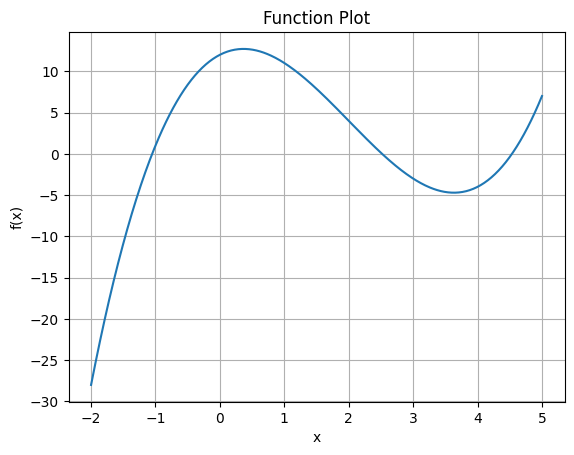

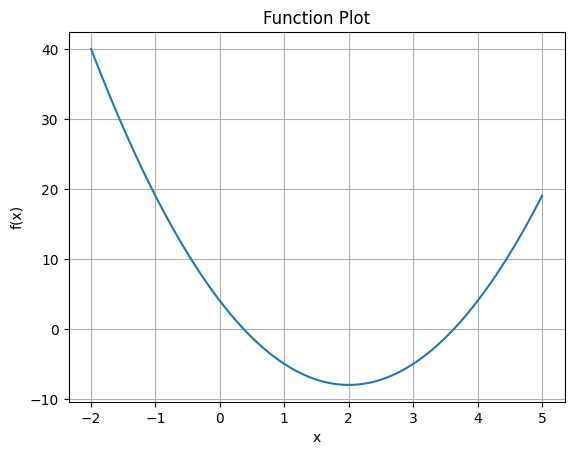

Startar Newton-Raphson vid x0 = 0
Iter  x_nuvarande     f(x)            f'(x)           Nästa steg (dx)
---------------------------------------------------------------------------
1     0.000000        12.000000       4.000000        -3.000000      
2     -3.000000       -81.000000      67.000000       1.208955       
3     -1.791045       -20.156615      35.116061       0.574000       
4     -1.217045       -3.558054       23.048134       0.154375       
5     -1.062670       -0.226323       20.139842       0.011238       
6     -1.051432       -0.001159       19.933719       0.000058       
7     -1.051374       -0.000000       19.932654       0.000000       

Konvergerade! Roten är ca -1.05137424
Startar Newton-Raphson vid x0 = 2
Iter  x_nuvarande     f(x)            f'(x)           Nästa steg (dx)
---------------------------------------------------------------------------
1     2.000000        4.000000        -8.000000       0.500000       
2     2.500000        0.125000        -7.

In [7]:
e_2_3_a = lambda x: x**3 - 6*x**2 + 4*x + 12
e_2_3_a_prime = lambda x: 3*x**2 - 12*x + 4

plot_function(e_2_3_a, start=-2, end=5)
plot_function(e_2_3_a_prime, start=-2, end=5)

r1 = newton_raphson_with_check(f=e_2_3_a, f_prime=e_2_3_a_prime, x0=0)
r2 = newton_raphson_with_check(f=e_2_3_a, f_prime=e_2_3_a_prime, x0=2)
r3 = newton_raphson_with_check(f=e_2_3_a, f_prime=e_2_3_a_prime, x0=4)
print(f"Root 1: {r1}, Root 2: {r2}, Root 3: {r3}")

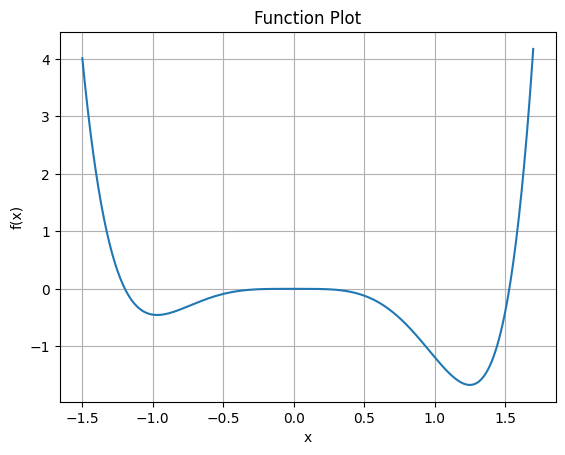

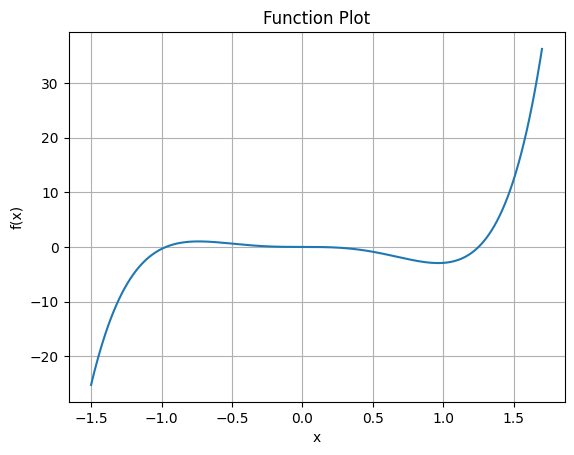

Startar Newton-Raphson vid x0 = -2
Iter  x_nuvarande     f(x)            f'(x)           Nästa steg (dx)
---------------------------------------------------------------------------
1     -2.000000       39.471504       -140.486705     0.280963       
2     -1.719037       12.800332       -58.460251      0.218958       
3     -1.500080       4.013281        -25.242831      0.158987       
4     -1.341093       1.157521        -11.870626      0.097511       
5     -1.243581       0.266358        -6.729306       0.039582       
6     -1.203999       0.032103        -5.150909       0.006232       
7     -1.197767       0.000705        -4.925681       0.000143       
8     -1.197624       0.000000        -4.920580       0.000000       
9     -1.197624       0.000000        -4.920577       0.000000       

Konvergerade! Roten är ca -1.19762372
Startar Newton-Raphson vid x0 = 0.5
Iter  x_nuvarande     f(x)            f'(x)           Nästa steg (dx)
--------------------------------------------

In [8]:
e_2_3_b = lambda x: np.exp(np.sin(x)**3) + x**6 - 2*x**4 - x**3 - 1
e_2_3_b_prime = lambda x: (np.exp(np.sin(x)**3) * 3 * (np.sin(x)**2) * np.cos(x)) + 6*x**5 - 8*x**3 - 3*x**2

plot_function(e_2_3_b, start=-1.5, end=1.7)
plot_function(e_2_3_b_prime, start=-1.5, end=1.7)

r1 = newton_raphson_with_check(f=e_2_3_b, f_prime=e_2_3_b_prime, x0=-2)
r2 = newton_raphson_with_check(f=e_2_3_b, f_prime=e_2_3_b_prime, x0=0.5)
r3 = newton_raphson_with_check(f=e_2_3_b, f_prime=e_2_3_b_prime, x0=1.5)
print(f"Root 1: {r1}, Root 2: {r2}, Root 3: {r3}")


r2_secant = secant_method(e_2_3_b, -0.5, 0.5)

print(f"Root 2 fast secant: {r2_secant}")

# Assignment 3

## 3.1

In [9]:
import numpy as np

def f(x):
    x1, x2, x3 = x
    # The system of equations from the PDF
    f1 = x1**2 - 2*x1 + x2**2 - x3 + 1
    f2 = x1*(x2**2) - x1 - 3*x2 + x2*x3 + 2
    f3 = x1*(x3**2) - 3*x3 + x2*(x3**2) + x1*x2
    return np.array([f1, f2, f3])

def jacobian(x):
    x1, x2, x3 = x
    # Partial derivatives matrix (J)
    # Row 1 derivatives (df1/dx1, df1/dx2, df1/dx3)
    df1 = [2*x1 - 2,  2*x2,  -1]
    
    # Row 2 derivatives (df2/dx1, df2/dx2, df2/dx3)
    # f2 = x1*x2^2 - x1 - 3x2 + x2*x3 + 2
    df2 = [x2**2 - 1,  2*x1*x2 - 3 + x3,  x2]
    
    # Row 3 derivatives (df3/dx1, df3/dx2, df3/dx3)
    # f3 = x1*x3^2 - 3x3 + x2*x3^2 + x1*x2
    df3 = [x3**2 + x2,  x3**2 + x1,  2*x1*x3 - 3 + 2*x2*x3]
    
    return np.array([df1, df2, df3])

# Initial guess x^(0) = [1, 2, 3]
x = np.array([1.0, 2.0, 3.0])
r_true = np.array([1.0, 1.0, 1.0]) # Given hint for convergence check

print(f"{'Iter':<5} {'x1':<10} {'x2':<10} {'x3':<10} {'Error e^(k)':<15}")

# Perform 6 iterations
error_prev = None
for k in range(1, 7):
    # Newton Step: Solve J * delta_x = -f(x)
    J = jacobian(x)
    fx = f(x)
    delta_x = np.linalg.solve(J, -fx)
    
    x = x + delta_x
    
    # Calculate error ||r - x^(k)||2
    error = np.linalg.norm(r_true - x, 2)
    print(f"Previous error: {error_prev}, current error {error}, quota {error / error_prev if error_prev else 'nah'}")
    print(f"{k:<5} {x[0]:.4f}     {x[1]:.4f}     {x[2]:.4f}     {error:.4e}")
    
    error_prev = error

print(f"\nFinal approximation x^(6): {x}")
error

Iter  x1         x2         x3         Error e^(k)    
Previous error: None, current error 1.9138238930191893, quota nah
1     0.1026     1.6410     2.5641     1.9138e+00
Previous error: 1.9138238930191893, current error 1.040352758553732, quota 0.5435990021592341
2     1.5206     1.4111     0.1986     1.0404e+00
Previous error: 1.040352758553732, current error 0.974322445982013, quota 0.9365308429964541
3     1.9412     0.7713     0.8947     9.7432e-01
Previous error: 0.974322445982013, current error 0.5548246619249351, quota 0.5694466592789321
4     1.0674     1.1912     0.4835     5.5482e-01
Previous error: 0.5548246619249351, current error 0.2976814736262033, quota 0.5365325192889102
5     1.2683     0.9518     0.8803     2.9768e-01
Previous error: 0.2976814736262033, current error 0.06199045289993919, quota 0.20824424222576982
6     0.9590     1.0338     0.9681     6.1990e-02

Final approximation x^(6): [0.95898753 1.03383592 0.96812644]


np.float64(0.06199045289993919)

## 3.2

In [10]:
import numpy as np

def jacobi_solver(A, b, x0, iterations):
    x = x0.copy()
    n = len(b)
    
    for k in range(iterations):
        x_new = np.zeros_like(x)
        for i in range(n):
            # Sum of a_ij * x_j for j != i
            s = sum(A[i][j] * x[j] for j in range(n) if i != j)
            x_new[i] = (b[i] - s) / A[i][i]
        x = x_new
    return x

A = np.array([
    [3.0, 1.0, 1.0, 0.0],
    [1.0, 6.0, 3.0, -1.0],
    [6.0, 0.0, 9.0, -2.0],
    [1.0, 0.0, -1.0, -7.0]
])

# RHS vector b
b = np.array([10.0, 1.0, 1.0, 1.0])

# Initial guess x^(0) = [0, 1, 1, 0]
x0 = np.array([0.0, 1.0, 1.0, 0.0])

final_x = jacobi_solver(A, b, x0, 25)
norm_val = np.linalg.norm(final_x, 2)

print(f"Solution x^(25): {final_x}")
print(f"Norm ||x^(25)||2: {norm_val:.4f}")

Solution x^(25): [ 3.83001459  0.7900146  -2.27998541  0.73      ]
Norm ||x^(25)||2: 4.5852


## 3.3

In [11]:
import numpy as np

def gauss_seidel_solver(A, b, x0, iterations):
    x = x0.copy()
    n = len(b)
    
    for k in range(iterations):
        for i in range(n):
            # Use new values for j < i and old values for j > i
            # In Python, since we update 'x' in place, this happens naturally!
            s = sum(A[i][j] * x[j] for j in range(n) if i != j)
            x[i] = (b[i] - s) / A[i][i]
    return x

# Matrix A and vector b from Exercise 3
A = np.array([
    [15.0, -5.0, 1.0, 1.1],
    [0.0, 7.0, 2.0, -1.0],
    [2.0, -1.0, 9.0, -1.0],
    [1.0, 1.1, -1.0, -6.0]
])

b = np.array([1.0, 1.0, 1.0, 1.0])

# Initial guess x^(0) = [2, 1, 1, 1]
x0 = np.array([2.0, 1.0, 1.0, 1.0])

final_x = gauss_seidel_solver(A, b, x0, 10)
norm_val = np.linalg.norm(final_x, 2)

print(f"Solution x^(10): {final_x}")
print(f"Norm ||x^(10)||2: {norm_val:.4f}")

Solution x^(10): [ 0.10462309  0.09852053  0.08270258 -0.14495115]
Norm ||x^(10)||2: 0.2202


## 3.4

In [12]:
import numpy as np

def solve_questions():
    # --- QUESTION 1: Newton's Method ---
    print("--- Question 1 (Newton) ---")
    def f(x):
        return np.array([
            x[0]**2 - 2*x[0] + x[1]**2 - x[2] + 1,
            x[0]*x[1]**2 - x[0] - 3*x[1] + x[1]*x[2] + 2,
            x[0]*x[2]**2 - 3*x[2] + x[1]*x[2]**2 + x[0]*x[1]
        ])

    def J(x):
        return np.array([
            [2*x[0] - 2, 2*x[1], -1],
            [x[1]**2 - 1, 2*x[0]*x[1] - 3 + x[2], x[1]],
            [x[2]**2 + x[1], x[2]**2 + x[0], 2*x[0]*x[2] - 3 + 2*x[1]*x[2]]
        ])

    x = np.array([1.0, 2.0, 3.0])
    r = np.array([1.0, 1.0, 1.0])
    errors = []
    
    for k in range(6):
        delta = np.linalg.solve(J(x), -f(x))
        x = x + delta
        err = np.linalg.norm(r - x, 2)
        errors.append(err)
    
    if errors[-2] != 0:
        ratio = errors[-1] / errors[-2]
        print(f"k=6 Error Ratio: {ratio:.4f}")
    else:
        print("Error became 0, ratio undefined (Quadratic convergence achieved).")

    # --- QUESTION 2: Jacobi Method ---
    print("\n--- Question 2 (Jacobi) ---")
    A = np.array([[3, 1, 1, 0], [1, 6, 3, -1], [6, 0, 9, -2], [1, 0, -1, -7]], dtype=float)
    b = np.array([10, 1, 1, 1], dtype=float)
    x = np.array([0, 1, 1, 0], dtype=float)
    
    D = np.diag(A)
    R = A - np.diag(D)
    
    for _ in range(25):
        x = (b - R @ x) / D
    
    print(f"Norm of x(25): {np.linalg.norm(x, 2):.4f}")

    # --- QUESTION 3: Gauss-Seidel Method ---
    print("\n--- Question 3 (Gauss-Seidel) ---")
    A_gs = np.array([[15, -5, 1, 1.1], [0, 7, 2, -1], [2, -1, 9, -1], [1, 1.1, -1, -6]], dtype=float)
    b_gs = np.array([1, 1, 1, 1], dtype=float)
    x_gs = np.array([2, 1, 1, 1], dtype=float)
    n = len(b_gs)
    
    for _ in range(10):
        for i in range(n):
            s = sum(A_gs[i][j] * x_gs[j] for j in range(n) if j != i)
            x_gs[i] = (b_gs[i] - s) / A_gs[i][i]
            
    print(f"Norm of x(10): {np.linalg.norm(x_gs, 2):.4f}")

if __name__ == "__main__":
    solve_questions()

--- Question 1 (Newton) ---
k=6 Error Ratio: 0.2082

--- Question 2 (Jacobi) ---
Norm of x(25): 4.5852

--- Question 3 (Gauss-Seidel) ---
Norm of x(10): 0.2202


# Assignment 5

## 5.1

In [13]:
import numpy as np
import scipy.linalg as la

# ==========================================
# 1. GENERAL SOLVER FUNCTIONS
# ==========================================

def solve_least_squares_lu(A, b):
    """
    Solves the overdetermined system Ac = b using the Normal Equations (A^T A c = A^T b)
    and LU decomposition.
    """
    M = A.T @ A
    v = A.T @ bimport numpy as np

# ==========================================
# 1. GRAM-SCHMIDT SOLVER FUNCTION
# ==========================================

def get_y2_norm(A):
    """
    Extracts the first two columns of matrix A, performs the first two steps
    of the Gram-Schmidt process, and returns the L2 norm of the intermediate vector y2.
    """
    # Extract the first two column vectors (v1 and v2)
    v1 = A[:, 0]
    v2 = A[:, 1]
    
    # Step 1: First basis vector
    y1 = v1
    q1 = y1 / np.linalg.norm(y1, ord=2)
    
    # Step 2: Second intermediate vector (y2)
    # y2 = v2 - (projection of v2 onto q1)
    projection = np.dot(q1, v2) * q1
    y2 = v2 - projection
    
    # Calculate the L2 norm of y2
    y2_norm = np.linalg.norm(y2, ord=2)
    
    return y2_norm

# ==========================================
# 2. ASSIGNMENT 2 DATA SETUP
# ==========================================

# NOTE: Replace this array with the exact matrix from your PDF!
# Enter the matrix row by row. 
A = np.array([
    [4.0,  2.0,  3.0],
    [0.0, -2.0, -1.0],
    [1.0,  1.0,  1.0],
    [3.0,  1.0,  3.0],
    [-1.0,-1.0, -2.0]
])

# ==========================================
# 3. EXECUTION
# ==========================================

# Calculate the norm of y2
norm_y2 = get_y2_norm(A)

# Output the result rounded to 4 decimal places
print(f"The norm ||y_2||_2 is: {norm_y2:.4f}")
    
    # LU Decomposition
    P, L, U = la.lu(M)
    
    # Forward substitution: Ly = P^T v
    y = la.solve_triangular(L, P.T @ v, lower=True)
    
    # Backward substitution: Uc = y
    c = la.solve_triangular(U, y)
    
    return c

def solve_least_squares_qr(A, b):
    """
    Solves the overdetermined system Ac = b using Reduced QR Decomposition (A = QR).
    More numerically stable than the Normal Equations.
    """
    # Reduced QR Decomposition
    Q, R = la.qr(A, mode='economic')
    
    # Project b onto the column space of Q
    d = Q.T @ b
    
    # Backward substitution: Rc = d
    c = la.solve_triangular(R, d)
    
    return c

# ==========================================
# 2. ASSIGNMENT 1 DATA SETUP
# ==========================================

# Raw data from the table
years = np.array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003])
production = np.array([67052, 68008, 69803, 72024, 73400, 72063, 74669, 74487, 74065, 76777]) # bbl/day x 10^6

# Time scaling: 1994 -> t=0
t = years - 1994

# Construct the Vandermonde matrix A for a cubic polynomial (degree 3)
A = np.column_stack([t**0, t**1, t**2, t**3])
b = production

# ==========================================
# 3. EXECUTION AND PREDICTION
# ==========================================

# Solve for coefficients using both methods
c_lu = solve_least_squares_lu(A, b)
c_qr = solve_least_squares_qr(A, b)

# Target year 2026 scaled
t_target = 2026 - 1994

# Evaluate the polynomial for 2026
# y(t) = c_0 + c_1*t + c_2*t^2 + c_3*t^3
y_pred_lu = c_lu[0] + c_lu[1]*t_target + c_lu[2]*(t_target**2) + c_lu[3]*(t_target**3)
y_pred_qr = c_qr[0] + c_qr[1]*t_target + c_qr[2]*(t_target**2) + c_qr[3]*(t_target**3)

# Output results with commercial rounding as requested
print(f"Prediction using LU (Normal Eq): {np.round(y_pred_lu).astype(int)}")
print(f"Prediction using QR:             {np.round(y_pred_qr).astype(int)}")

Prediction using LU (Normal Eq): 416210
Prediction using QR:             416210


## 5.2

In [14]:
import numpy as np

# ==========================================
# 1. GRAM-SCHMIDT SOLVER FUNCTION
# ==========================================

def get_y2_norm(A):
    """
    Extracts the first two columns of matrix A, performs the first two steps
    of the Gram-Schmidt process, and returns the L2 norm of the intermediate vector y2.
    """
    # Extract the first two column vectors (v1 and v2)
    v1 = A[:, 0]
    v2 = A[:, 1]
    
    # Step 1: First basis vector
    y1 = v1
    q1 = y1 / np.linalg.norm(y1, ord=2)
    
    # Step 2: Second intermediate vector (y2)
    # y2 = v2 - (projection of v2 onto q1)
    projection = np.dot(q1, v2) * q1
    y2 = v2 - projection
    
    # Calculate the L2 norm of y2
    y2_norm = np.linalg.norm(y2, ord=2)
    
    return y2_norm

# ==========================================
# 2. ASSIGNMENT 2 DATA SETUP
# ==========================================

# NOTE: Replace this array with the exact matrix from your PDF!
# Enter the matrix row by row. 
A = np.array([
    [4.0,  2.0,  3.0, 0],
    [-2.0, 3, -1.0, 1],
    [1.0,  3.0,  -4, 2],
    [1,  0, 1, -1],
    [3,1.0, 3.0, -2]
])

# ==========================================
# 3. EXECUTION
# ==========================================

# Calculate the norm of y2
norm_y2 = get_y2_norm(A)

# Output the result rounded to 4 decimal places
print(f"The norm ||y_2||_2 is: {norm_y2:.4f}")

The norm ||y_2||_2 is: 4.5755


## 5.3

In [15]:
import numpy as np
import scipy.linalg as la

# ==========================================
# 1. GENERAL SOLVER FUNCTION
# ==========================================

def get_R_condition_number(A):
    """
    Performs a reduced QR decomposition on matrix A and calculates 
    the 2-norm condition number of the resulting upper triangular matrix R.
    """
    # Reduced QR Decomposition (mode='economic' returns reduced Q and R)
    Q, R = la.qr(A, mode='economic')
    
    # Calculate the condition number of R w.r.t the 2-norm
    cond_R = np.linalg.cond(R, p=2)
    
    return cond_R

# ==========================================
# 2. ASSIGNMENT 3 DATA SETUP
# ==========================================

# Generate 12 evenly spaced points between 1 and 5
x = np.linspace(1, 5, 12)

# Set the degree of the polynomial
d = 5

# Generate y values: sum(x^k) for k=0 to 5
# Note: This is included for completeness, though not strictly needed for cond(R)
y = sum([x**k for k in range(d + 1)])

# Construct the 12x6 Vandermonde matrix A
# np.vander generates x^(N-1) down to x^0, so we flip it to match our standard formulation
A = np.vander(x, d + 1, increasing=True)

# ==========================================
# 3. EXECUTION
# ==========================================

# Calculate the condition number of R
cond_num = get_R_condition_number(A)

# Output the result rounded to the nearest integer
print(f"The condition number of R is: {np.round(cond_num).astype(int)}")

The condition number of R is: 322081
